In [1]:
import pandas as pd
import numpy as np
import os
import seaborn as sns

pd.set_option('display.max_colwidth', 40)

In [2]:
list_dfs = []

for _,_, files in os.walk('dataset'):
	for file in files:
		if file.split('.')[-1] == 'csv':
			list_dfs.append(pd.read_csv(f'dataset\{file}'))

len(list_dfs)

14

In [3]:
df = pd.concat(list_dfs).reset_index().drop(columns='index')

columns_to_rename = {
    "TAA":"alerts", 
    "TA": "departure_hour_delayed", 
    "TIN":"train_model", 
    "TIR":"route", 
    "TSI":"station_id", 
    "TIM":"direction", 
    "TIL":"request", 
    "TIRE":"destination",
    "TIP":"plattform", 
    "TIT": "departure_hour", 
    "TID":"date", 
    "TSC":"station_and_id", 
    "TAc":"delay_in_minutes"}

df = df.rename(columns=columns_to_rename)

df.head()

,alerts,departure_hour_delayed,train_model,route,station_id,direction,request,destination,plattform,departure_hour,date,station_and_id,delay_in_minutes
0,,NaN,RE 5(28522),Koblenz Hbf 14:17-Koblenz Stadtmitte...,8000044.0,arr,/bin/traininfo.exe/dn/5337/348632/44...,Koblenz Hbf,1,15:02,16.06.19,Bonn%238000044,0
1,,NaN,RB48(32455),Wuppertal-Oberbarmen 13:38-Wuppertal...,8000044.0,arr,/bin/traininfo.exe/dn/141795/395026/...,Wuppertal-Oberbarmen,3,15:06,16.06.19,Bonn%238000044,0
2,,NaN,IC2217,Stralsund Hbf 07:27-Velgast 07:41-Ri...,8000044.0,arr,/bin/traininfo.exe/dn/587844/488434/...,Stralsund Hbf,3,15:12,16.06.19,Bonn%238000044,0
3,,NaN,RB30(11119),Ahrbrück 14:03-Altenahr 14:11-Dernau...,8000044.0,arr,/bin/traininfo.exe/dn/255588/394368/...,Ahrbrück,2,15:12,16.06.19,Bonn%238000044,0
4,,NaN,S 23,Euskirchen 14:36-Swisttal-Odendorf 1...,8000044.0,arr,/bin/traininfo.exe/dn/707163/545356/...,Euskirchen,5,15:20,16.06.19,Bonn%238000044,0


# Data Cleaning

In [40]:
stations = df['station_and_id'].unique()
stations.sort()
for i_station in stations:
    print(i_station)

Berlin%238011160
Berlin%238089021
Bonn%238000044
Bremen%238000050
Dresden%238010085
Frankfurt%238000105
Hamburg%238002549
Hannover%238000152
K%C3%B6ln%238000207
Koblenz%238000206
Koeln%238000207
Mainz%238000240
Muenchen%238000261
Stuttgart%238098096


<div style="border-radius:10px; border:#125899 solid; padding: 15px; background-color: #a3bfd9; font-size:100%; text-align:left; color: #000000">

<h3 align="left"><font color='#125899'>📍 Inference Train types</font></h3>
    
<li> Lines are defined by the [letters and spaces] in the beginning, followed by space and/or numbers, a new columns will be created with the identification in the beginning
</div>
df['line_type'] = df['train_model'].str.extract(pat='(^[^\d(]*)')
df['line_type'] = df['line_type'].str.strip()

In [4]:
df = df.drop(columns='request')

print('Duplicated values removed: ', df.duplicated().sum())

df = df.sort_values('alerts', ascending=False).drop_duplicates()

Duplicated values removed:  237046


In [5]:
df[df['departure_hour_delayed'].isna()]['delay_in_minutes'].unique()

array([-1,  0], dtype=int64)

<AxesSubplot: >

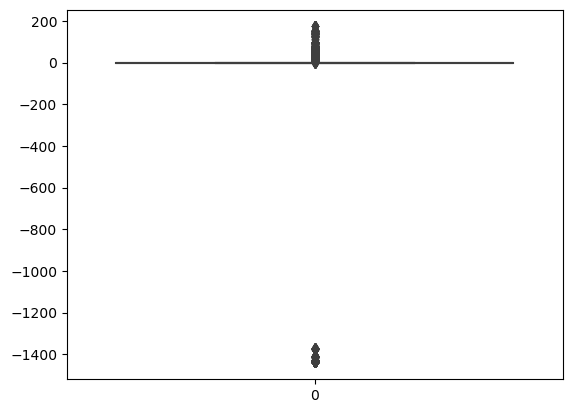

In [6]:
sns.boxplot(df['delay_in_minutes'].values)

In [7]:
late_values = df.query('delay_in_minutes < 0')['delay_in_minutes'].unique()
late_values[::-1].sort()
print(late_values)

[   -1 -1371 -1372 -1373 -1374 -1375 -1408 -1409 -1410 -1411 -1412 -1414
 -1416 -1417 -1418 -1419 -1426 -1427 -1428 -1429 -1430 -1431 -1432 -1433
 -1434 -1435 -1436 -1437 -1438 -1439]


<div style="border-radius:10px; border:#125899 solid; padding: 15px; background-color: #a3bfd9; font-size:100%; text-align:left; color: #000000">

<h3 align="left"><font color='#125899'>📍 Inference on delays (in minutes) and departure delays</font></h3>
    
<li> Where departure_hour_delayed is NaN, the departure was punctual, therefore this column should be the same as departure_hour
<li> The values with -1 should be considered 0, as they were punctual
<li> Below -1 the values indicates around 24 hours of early departure (1440 minutes), as this is impossible there will be considered a wrong date input and will be added 1440 for the analysis
</div>

In [8]:
df['departure_hour_delayed'] = np.where(df['departure_hour_delayed'].isna(), df['departure_hour'], df['departure_hour_delayed'])
df['delay_in_minutes'] = df['delay_in_minutes'].replace({-1:0})
df['delay_in_minutes'] = df['delay_in_minutes'] + np.where(df['delay_in_minutes'] < -1, 1440, 0)

df.head()

,alerts,departure_hour_delayed,train_model,route,station_id,direction,destination,plattform,departure_hour,date,station_and_id,delay_in_minutes
228284,Änderung im Fahrtverlauf!@@Grund: Z...,20:38,RE50(4531),Fulda 19:04-Neuhof(Kr Fulda) 19:18-F...,8000105.0,arr,Fulda,5,20:28,20.06.19,Frankfurt%238000105,10
228845,Änderung im Fahrtverlauf!@@Grund: Z...,20:45,RE50(4531),Fulda 19:04-Schlüchtern 19:30-Wächte...,8000105.0,arr,Fulda,5,20:28,20.06.19,Frankfurt%238000105,17
85451,Änderung im Fahrtverlauf!@@Grund: Z...,17:21,RE 3(3333),Eberswalde Hbf 16:42-Melchow16:48-Bi...,8089021.0,arr,Eberswalde Hbf,4Berlin Hbf (tief),17:20,20.06.19,Berlin%238089021,1
85082,Änderung im Fahrtverlauf!@@Grund: Z...,17:23,RE 3(3333),Eberswalde Hbf 16:42-Melchow16:48-Bi...,8089021.0,arr,Eberswalde Hbf,4Berlin Hbf (tief),17:20,20.06.19,Berlin%238089021,3
362618,Änderung im Fahrtverlauf!@@Grund: Z...,15:24,EC 8,Zürich HB 11:00-Basel SBB 12:20-Base...,8000240.0,arr,Zürich HB,3a/b,15:18,20.06.19,Mainz%238000240,6


In [9]:
df.isna().sum()

alerts                    2
departure_hour_delayed    4
train_model               4
route                     4
station_id                4
direction                 4
destination               4
plattform                 4
departure_hour            4
date                      4
station_and_id            4
delay_in_minutes          0
dtype: int64

In [10]:
df[df['alerts'].isna()]

,alerts,departure_hour_delayed,train_model,route,station_id,direction,destination,plattform,departure_hour,date,station_and_id,delay_in_minutes
7815,NaN,20:12,RB30(11129),Ahrbrück 19:03-Heimersheim 19:37-Bad...,8000044.0,arr,Ahrbrück,2,20:12,16.06.19,Bonn%238000044,0
211238,NaN,14:51,RE 2(4261),Koblenz Hbf 13:04-Boppard Hbf 13:16-...,8000105.0,arr,Koblenz Hbf,20,14:49,20.06.19,Frankfurt%238000105,2


In [11]:
df[df['plattform'].isna()].sum()

alerts                     Änderung im Fahrtverlauf!@@Grund: V...
departure_hour_delayed                                          0
train_model                                                     0
route                                                           0
station_id                                                    0.0
direction                                                       0
destination                                                     0
plattform                                                       0
departure_hour                                                  0
date                                                            0
station_and_id                                                  0
delay_in_minutes                                                0
dtype: object

<div style="border-radius:10px; border:#125899 solid; padding: 15px; background-color: #a3bfd9; font-size:100%; text-align:left; color: #000000">

<h3 align="left"><font color='#125899'>📍 Inference empty values</font></h3>
    
<li> NaN alerts can be safely casted to an empty string as they were punctual or mostly punctual (2 min delay)
<li> The rest of NaN can be dropped, as the whole entries is empty
</div>

In [12]:
df['alerts'] = df['alerts'].fillna('')
df = df.dropna()
df.shape

(222334, 12)

In [13]:
df.query('train_model == "ICE372"')

,alerts,departure_hour_delayed,train_model,route,station_id,direction,destination,plattform,departure_hour,date,station_and_id,delay_in_minutes
207426,Grund: Technische Störung am Zug@@G...,13:37,ICE372,Interlaken Ost 06:00-Interlaken West...,8000105.0,arr,Interlaken Ost,19,11:08,20.06.19,Frankfurt%238000105,149
205365,Grund: Technische Störung am Zug,13:40,ICE372,Interlaken Ost 06:00-Interlaken West...,8000105.0,arr,Interlaken Ost,9,11:08,20.06.19,Frankfurt%238000105,152
205428,Grund: Technische Störung am Zug,13:39,ICE372,Interlaken Ost 06:00-Interlaken West...,8000105.0,arr,Interlaken Ost,9,11:08,20.06.19,Frankfurt%238000105,151
205617,Grund: Technische Störung am Zug,13:38,ICE372,Interlaken Ost 06:00-Interlaken West...,8000105.0,arr,Interlaken Ost,9,11:08,20.06.19,Frankfurt%238000105,150
204725,Grund: Technische Störung am Zug,13:42,ICE372,Interlaken Ost 06:00-Interlaken West...,8000105.0,arr,Interlaken Ost,9,11:08,20.06.19,Frankfurt%238000105,154
206573,Grund: Technische Störung am Zug,13:35,ICE372,Interlaken Ost 06:00-Interlaken West...,8000105.0,arr,Interlaken Ost,9,11:08,20.06.19,Frankfurt%238000105,147
206898,Grund: Technische Störung am Zug,13:36,ICE372,Interlaken Ost 06:00-Interlaken West...,8000105.0,arr,Interlaken Ost,9,11:08,20.06.19,Frankfurt%238000105,148
205935,Grund: Technische Störung am Zug,13:37,ICE372,Interlaken Ost 06:00-Interlaken West...,8000105.0,arr,Interlaken Ost,9,11:08,20.06.19,Frankfurt%238000105,149
205872,Grund: Technische Störung am Zug,13:34,ICE372,Interlaken Ost 06:00-Interlaken West...,8000105.0,arr,Interlaken Ost,9,11:08,20.06.19,Frankfurt%238000105,146
200094,Grund: Notarzteinsatz am Gleis,13:39,ICE372,Interlaken Ost 06:00-Interlaken West...,8000105.0,arr,Interlaken Ost,9,11:08,20.06.19,Frankfurt%238000105,151


In [14]:
df.query('train_model == "ICE372"').groupby(['alerts', 'train_model', 'route', 'station_id', 'direction', 'destination', 'departure_hour', 'date', 'station_and_id']).count()

departure_hour_delayed  \
alerts                                   train_model route                                    station_id direction destination       departure_hour date     station_and_id                                
                                         ICE372      Interlaken Ost 06:00-Interlaken West ... 8000105.0  arr       Interlaken Ost    11:08          20.06.19 Frankfurt%238000105                       1   
                                                     Interlaken Ost 06:00-Interlaken West ... 8011160.0  arr       Interlaken Ost    16:01          20.06.19 Berlin%238011160                          1   
 Grund: Notarzteinsatz am Gleis          ICE372      Frankfurt(Main)Hbf 11:14-Hanau Hbf 11... 8000105.0  dep       Berlin Ostbahnhof 11:14          20.06.19 Frankfurt%238000105                       4   
                                                     Interlaken Ost 06:00-Interlaken West ... 8000105.0  arr       Interlaken Ost    11:08          20.06.19 Frankfurt%238000105                       6   
 Grund: Technische Störung am Zug        ICE372      Interlaken Ost 06:00-Interlaken West ... 8000105.0  arr       Interlaken Ost    11:08          20.06.19 Frankfurt%238000105                       8   
 Grund: Technische Störung am Zug@@Gl... ICE372      Interlaken Ost 06:00-Interlaken West ... 8000105.0  arr       Interlaken Ost    11:08          20.06.19 Frankfurt%238000105                       1   

                                                                                                                                                                                  plattform  \
alerts                                   train_model route                                    station_id direction destination       departure_hour date     station_and_id                   
                                         ICE372      Interlaken Ost 06:00-Interlaken West ... 8000105.0  arr       Interlaken Ost    11:08          20.06.19 Frankfurt%238000105          1   
                                                     Interlaken Ost 06:00-Interlaken West ... 8011160.0  arr       Interlaken Ost    16:01          20.06.19 Berlin%238011160             1   
 Grund: Notarzteinsatz am Gleis          ICE372      Frankfurt(Main)Hbf 11:14-Hanau Hbf 11... 8000105.0  dep       Berlin Ostbahnhof 11:14          20.06.19 Frankfurt%238000105          4   
                                                     Interlaken Ost 06:00-Interlaken West ... 8000105.0  arr       Interlaken Ost    11:08          20.06.19 Frankfurt%238000105          6   
 Grund: Technische Störung am Zug        ICE372      Interlaken Ost 06:00-Interlaken West ... 8000105.0  arr       Interlaken Ost    11:08          20.06.19 Frankfurt%238000105          8   
 Grund: Technische Störung am Zug@@Gl... ICE372      Interlaken Ost 06:00-Interlaken West ... 8000105.0  arr       Interlaken Ost    11:08          20.06.19 Frankfurt%238000105          1   

                                                                                                                                                                                  delay_in_minutes  
alerts                                   train_model route                                    station_id direction destination       departure_hour date     station_and_id                         
                                         ICE372      Interlaken Ost 06:00-Interlaken West ... 8000105.0  arr       Interlaken Ost    11:08          20.06.19 Frankfurt%238000105                 1  
                                                     Interlaken Ost 06:00-Interlaken West ... 8011160.0  arr       Interlaken Ost    16:01          20.06.19 Berlin%238011160                    1  
 Grund: Notarzteinsatz am Gleis          ICE372      Frankfurt(Main)Hbf 11:14-Hanau Hbf 11... 8000105.0  dep       Berlin Ostbahnhof 11:14          20.06.19 Frankfurt%238000105                 4  
                               

<div style="border-radius:10px; border:#125899 solid; padding: 15px; background-color: #a3bfd9; font-size:100%; text-align:left; color: #000000">

<h3 align="left"><font color='#125899'>📍 Inference same line</font></h3>
    
<li> Above we can see that the delays are updated and get a new entry on the database, as we are only interested in the maximum delay that it happend. We will get the max value of the grouping of the following columns: <b>'alerts', 'train_model', 'route', 'station_id', 'direction', 'destination', 'departure_hour', 'date', 'station_and_id'<\b>
</div>

In [15]:
df = df.sort_values('delay_in_minutes', ascending=False) \
	.drop_duplicates(subset=['alerts', 'train_model', 'route', 'station_id', 'direction', 'destination', 'departure_hour', 'date', 'station_and_id'])

df.query('train_model == "ICE372"').groupby(['alerts', 'train_model', 'route', 'station_id', 'direction', 'destination', 'departure_hour', 'date', 'station_and_id']).count()

departure_hour_delayed  \
alerts                                   train_model route                                    station_id direction destination       departure_hour date     station_and_id                                
                                         ICE372      Interlaken Ost 06:00-Interlaken West ... 8000105.0  arr       Interlaken Ost    11:08          20.06.19 Frankfurt%238000105                       1   
                                                     Interlaken Ost 06:00-Interlaken West ... 8011160.0  arr       Interlaken Ost    16:01          20.06.19 Berlin%238011160                          1   
 Grund: Notarzteinsatz am Gleis          ICE372      Frankfurt(Main)Hbf 11:14-Hanau Hbf 11... 8000105.0  dep       Berlin Ostbahnhof 11:14          20.06.19 Frankfurt%238000105                       1   
                                                     Interlaken Ost 06:00-Interlaken West ... 8000105.0  arr       Interlaken Ost    11:08          20.06.19 Frankfurt%238000105                       1   
 Grund: Technische Störung am Zug        ICE372      Interlaken Ost 06:00-Interlaken West ... 8000105.0  arr       Interlaken Ost    11:08          20.06.19 Frankfurt%238000105                       1   
 Grund: Technische Störung am Zug@@Gl... ICE372      Interlaken Ost 06:00-Interlaken West ... 8000105.0  arr       Interlaken Ost    11:08          20.06.19 Frankfurt%238000105                       1   

                                                                                                                                                                                  plattform  \
alerts                                   train_model route                                    station_id direction destination       departure_hour date     station_and_id                   
                                         ICE372      Interlaken Ost 06:00-Interlaken West ... 8000105.0  arr       Interlaken Ost    11:08          20.06.19 Frankfurt%238000105          1   
                                                     Interlaken Ost 06:00-Interlaken West ... 8011160.0  arr       Interlaken Ost    16:01          20.06.19 Berlin%238011160             1   
 Grund: Notarzteinsatz am Gleis          ICE372      Frankfurt(Main)Hbf 11:14-Hanau Hbf 11... 8000105.0  dep       Berlin Ostbahnhof 11:14          20.06.19 Frankfurt%238000105          1   
                                                     Interlaken Ost 06:00-Interlaken West ... 8000105.0  arr       Interlaken Ost    11:08          20.06.19 Frankfurt%238000105          1   
 Grund: Technische Störung am Zug        ICE372      Interlaken Ost 06:00-Interlaken West ... 8000105.0  arr       Interlaken Ost    11:08          20.06.19 Frankfurt%238000105          1   
 Grund: Technische Störung am Zug@@Gl... ICE372      Interlaken Ost 06:00-Interlaken West ... 8000105.0  arr       Interlaken Ost    11:08          20.06.19 Frankfurt%238000105          1   

                                                                                                                                                                                  delay_in_minutes  
alerts                                   train_model route                                    station_id direction destination       departure_hour date     station_and_id                         
                                         ICE372      Interlaken Ost 06:00-Interlaken West ... 8000105.0  arr       Interlaken Ost    11:08          20.06.19 Frankfurt%238000105                 1  
                                                     Interlaken Ost 06:00-Interlaken West ... 8011160.0  arr       Interlaken Ost    16:01          20.06.19 Berlin%238011160                    1  
 Grund: Notarzteinsatz am Gleis          ICE372      Frankfurt(Main)Hbf 11:14-Hanau Hbf 11... 8000105.0  dep       Berlin Ostbahnhof 11:14          20.06.19 Frankfurt%238000105                 1  
                               

In [16]:
df.query('train_model == "NJ 294"')

,alerts,departure_hour_delayed,train_model,route,station_id,direction,destination,plattform,departure_hour,date,station_and_id,delay_in_minutes
382938,,11:17,NJ 294,Roma Termini 18:58-Orvieto 19:51-Chi...,8000261.0,arr,Roma Termini,11,08:24,20.06.19,Muenchen%238000261,173
382788,,11:17,NJ 294,Roma Termini 18:58-Orvieto 19:51-Chi...,8000261.0,arr,Roma Termini,11,08:24,20.06.19,Muenchen%238000261,173
382638,,11:17,NJ 294,Roma Termini 18:58-Chiusi-Chianciano...,8000261.0,arr,Roma Termini,11,08:24,20.06.19,Muenchen%238000261,173
383238,Gleiswechsel,11:17,NJ 294,Roma Termini 18:58-Orvieto 19:51-Chi...,8000261.0,arr,Roma Termini,9,08:24,20.06.19,Muenchen%238000261,173
383088,Gleiswechsel,11:17,NJ 294,Roma Termini 18:58-Chiusi-Chianciano...,8000261.0,arr,Roma Termini,9,08:24,20.06.19,Muenchen%238000261,173
384138,,08:24,NJ 294,Roma Termini 18:58-Orvieto 19:51-Chi...,8000261.0,arr,Roma Termini,11,08:24,20.06.19,Muenchen%238000261,0
383988,,08:24,NJ 294,Roma Termini 18:58-Orvieto 19:51-Chi...,8000261.0,arr,Roma Termini,11,08:24,20.06.19,Muenchen%238000261,0
383538,,08:24,NJ 294,Roma Termini 18:58-Orvieto 19:51-Chi...,8000261.0,arr,Roma Termini,11,08:24,20.06.19,Muenchen%238000261,0
383838,,08:24,NJ 294,Roma Termini 18:58-Orvieto 19:51-Are...,8000261.0,arr,Roma Termini,11,08:24,20.06.19,Muenchen%238000261,0
384515,,08:24,NJ 294,Roma Termini 18:58-Orvieto 19:51-Chi...,8000261.0,arr,Roma Termini,11,08:24,20.06.19,Muenchen%238000261,0


<div style="border-radius:10px; border:#125899 solid; padding: 15px; background-color: #a3bfd9; font-size:100%; text-align:left; color: #000000">

<h3 align="left"><font color='#125899'>📍 Inference Gleiswechsel</font></h3>
    
<li> When the departure track is changed there is duplication, we'll remove the entry when there's no delay
</div>

In [17]:
df = df.sort_values('delay_in_minutes', ascending=False).drop_duplicates(subset=['train_model', 'route', 'station_id', 'direction', 'destination', 'departure_hour', 'date', 'station_and_id'])
df

,alerts,departure_hour_delayed,train_model,route,station_id,direction,destination,plattform,departure_hour,date,station_and_id,delay_in_minutes
382938,,11:17,NJ 294,Roma Termini 18:58-Orvieto 19:51-Chi...,8000261.0,arr,Roma Termini,11,08:24,20.06.19,Muenchen%238000261,173
383238,Gleiswechsel,11:17,NJ 294,Roma Termini 18:58-Orvieto 19:51-Chi...,8000261.0,arr,Roma Termini,9,08:24,20.06.19,Muenchen%238000261,173
382787,,11:17,NJ 40235,Milano Centrale 20:40-Milano Lambrat...,8000261.0,arr,Milano Centrale,-,08:24,20.06.19,Muenchen%238000261,173
383088,Gleiswechsel,11:17,NJ 294,Roma Termini 18:58-Chiusi-Chianciano...,8000261.0,arr,Roma Termini,9,08:24,20.06.19,Muenchen%238000261,173
383087,Gleiswechsel,11:17,NJ 40235,Milano Centrale 20:40-Desenzano del ...,8000261.0,arr,Milano Centrale,9,08:24,20.06.19,Muenchen%238000261,173
...,...,...,...,...,...,...,...,...,...,...,...,...
147066,,12:54,NWBRS1,Bremen-Farge 12:11-Bremen Turnerstra...,8000050.0,arr,Bremen-Farge,5,12:54,20.06.19,Bremen%238000050,0
147074,,12:22,NWB RB58(82256),Bremen Hbf 12:22-Bremen Neustadt 12:...,8000050.0,dep,Osnabrück Hbf,2,12:22,20.06.19,Bremen%238000050,0
169932,Sonderfahrt,23:42,STR13423,"Gröpelingen, Bremen 23:24-Waller Fri...",8000050.0,arr,"Gröpelingen, Bremen","CHauptbahnhof, Bremen",23:42,20.06.19,Bremen%238000050,0
147135,,12:38,NWB RB58(82255),Osnabrück Hbf 10:26-Holdorf(Oldb) 11...,8000050.0,arr,Osnabrück Hbf,2,12:38,20.06.19,Bremen%238000050,0


In [18]:
df.query('train_model == "NJ 40235"')

,alerts,departure_hour_delayed,train_model,route,station_id,direction,destination,plattform,departure_hour,date,station_and_id,delay_in_minutes
382787,,11:17,NJ 40235,Milano Centrale 20:40-Milano Lambrat...,8000261.0,arr,Milano Centrale,-,08:24,20.06.19,Muenchen%238000261,173
383087,Gleiswechsel,11:17,NJ 40235,Milano Centrale 20:40-Desenzano del ...,8000261.0,arr,Milano Centrale,9,08:24,20.06.19,Muenchen%238000261,173
383237,Gleiswechsel,11:17,NJ 40235,Milano Centrale 20:40-Milano Lambrat...,8000261.0,arr,Milano Centrale,9,08:24,20.06.19,Muenchen%238000261,173
382937,,11:17,NJ 40235,Milano Centrale 20:40-Brescia 21:44-...,8000261.0,arr,Milano Centrale,-,08:24,20.06.19,Muenchen%238000261,173
382487,,11:17,NJ 40235,Milano Centrale 20:40-Brescia 21:44-...,8000261.0,arr,Milano Centrale,-,08:24,20.06.19,Muenchen%238000261,173
384591,,08:24,NJ 40235,Milano Centrale 20:40-Milano Lambrat...,8000261.0,arr,Milano Centrale,-,08:24,20.06.19,Muenchen%238000261,0
384668,,08:24,NJ 40235,Milano Centrale 20:40-Milano Lambrat...,8000261.0,arr,Milano Centrale,-,08:24,20.06.19,Muenchen%238000261,0
384895,,08:24,NJ 40235,Milano Centrale 20:40-Milano Lambrat...,8000261.0,arr,Milano Centrale,-,08:24,20.06.19,Muenchen%238000261,0
384745,,08:24,NJ 40235,Milano Centrale 20:40-Desenzano del ...,8000261.0,arr,Milano Centrale,-,08:24,20.06.19,Muenchen%238000261,0
384514,,08:24,NJ 40235,Milano Centrale 20:40-Milano Lambrat...,8000261.0,arr,Milano Centrale,-,08:24,20.06.19,Muenchen%238000261,0


In [19]:
print(df.query('train_model == "NJ 40235"')['route'].iloc[0])
print(df.query('train_model == "NJ 40235"')['route'].iloc[1])

Milano Centrale 20:40-Milano Lambrate 20:50-Brescia 21:44-Desenzano del Garda/Sirmione 22:02-Peschiera del Garda 22:13-Verona Porta Nuova 22:52Villach Hbf 04:00-Schwarzach-St.Veit 05:20-Salzburg Hbf 06:27-München Hbf 08:24
Milano Centrale 20:40-Desenzano del Garda/Sirmione 22:02-Peschiera del Garda 22:13-Vicenza 23:24-Padova 23:44-Tarvisio Boscoverde 02:45Villach Hbf 04:00-Schwarzach-St.Veit 05:20-Salzburg Hbf 06:27-München Hbf 08:24


<div style="border-radius:10px; border:#125899 solid; padding: 15px; background-color: #a3bfd9; font-size:100%; text-align:left; color: #000000">

<h3 align="left"><font color='#125899'>📍 Inference Gleiswechsel</font></h3>
    
<li> When there's a change in the route there's a double entry, we have to remove that
</div>

In [20]:
df = df.sort_values('delay_in_minutes', ascending=False).drop_duplicates(subset=['train_model', 'station_id', 'direction', 'destination', 'departure_hour', 'date', 'station_and_id'])
df

,alerts,departure_hour_delayed,train_model,route,station_id,direction,destination,plattform,departure_hour,date,station_and_id,delay_in_minutes
382938,,11:17,NJ 294,Roma Termini 18:58-Orvieto 19:51-Chi...,8000261.0,arr,Roma Termini,11,08:24,20.06.19,Muenchen%238000261,173
382787,,11:17,NJ 40235,Milano Centrale 20:40-Milano Lambrat...,8000261.0,arr,Milano Centrale,-,08:24,20.06.19,Muenchen%238000261,173
203008,Grund: Notarzteinsatz am Gleis,13:44,ICE372,Interlaken Ost 06:00-Interlaken West...,8000105.0,arr,Interlaken Ost,9,11:08,20.06.19,Frankfurt%238000105,156
388464,Änderung im Fahrtverlauf!@@Grund: T...,12:30,ICE 1701,Berlin Hbf (tief) 05:34-Berlin Südkr...,8000261.0,arr,Berlin Hbf (tief),18,09:55,20.06.19,Muenchen%238000261,155
203668,Grund: Notarzteinsatz am Gleis,13:49,ICE372,Frankfurt(Main)Hbf 11:14-Hanau Hbf 1...,8000105.0,dep,Berlin Ostbahnhof,9,11:14,20.06.19,Frankfurt%238000105,155
...,...,...,...,...,...,...,...,...,...,...,...,...
368622,,17:17,RE14(4757),Mainz Hbf 17:17-Worms Hbf 17:44-Fran...,8000240.0,dep,Mannheim Hbf,6a,17:17,20.06.19,Mainz%238000240,0
368620,,17:03,RE13(29220),Mainz Hbf 17:03-Nieder Olm 17:17-Sau...,8000240.0,dep,Kirchheimbolanden,8,17:03,20.06.19,Mainz%238000240,0
314075,,23:04,BTE 1795,Hannover Hbf 23:04-Karlsruhe Hbf 04:...,8000152.0,dep,Lörrach Gbf ARZ,-,23:04,20.06.19,Hannover%238000152,0
367635,,17:31,S8,Wiesbaden Hbf 17:19-Wiesbaden Ost 17...,8000240.0,arr,Wiesbaden Hbf,4a,17:31,20.06.19,Mainz%238000240,0


In [21]:
# Random sampling for anomalies
df.sort_values('departure_hour').query(f'train_model == "{df["train_model"].sample(1).values[0]}"')

,alerts,departure_hour_delayed,train_model,route,station_id,direction,destination,plattform,departure_hour,date,station_and_id,delay_in_minutes
64550,,10:09,S3,Erkner (S) 09:25-Berlin Warschauer S...,8089021.0,arr,Erkner (S),16,10:09,20.06.19,Berlin%238089021,0
64615,,10:10,S3,Berlin Hbf (S-Bahn) 10:10-Berlin Bel...,8089021.0,dep,Berlin-Spandau (S),16,10:10,20.06.19,Berlin%238089021,0
64621,,10:15,S3,Berlin Hbf (S-Bahn) 10:15-Berlin Fri...,8089021.0,dep,Erkner (S),15,10:15,20.06.19,Berlin%238089021,0
64688,,10:15,S3,Berlin-Spandau (S) 09:48-Berlin Heer...,8089021.0,arr,Berlin-Spandau (S),15,10:15,20.06.19,Berlin%238089021,0
64572,,10:29,S3,Erkner (S) 09:45-Berlin Warschauer S...,8089021.0,arr,Erkner (S),16,10:29,20.06.19,Berlin%238089021,0
...,...,...,...,...,...,...,...,...,...,...,...,...
279289,,23:55,S3,Buxtehude 23:14-Neu Wulmstorf 23:19-...,8002549.0,arr,Buxtehude,1Hamburg Hbf (S-Bahn),23:55,20.06.19,Hamburg%238002549,0
103692,,23:55,S3,Berlin Hbf (S-Bahn) 23:55-Berlin Fri...,8089021.0,dep,Erkner (S),15,23:55,20.06.19,Berlin%238089021,0
279054,,23:56,S3,Hamburg Hbf (S-Bahn) 23:56-Hamburg J...,8002549.0,dep,Hamburg-Altona(S),1Hamburg Hbf (S-Bahn),23:56,20.06.19,Hamburg%238002549,0
421577,,23:57,S3,Holzkirchen 23:16-Furth(b Deisenhofe...,8000261.0,arr,Holzkirchen,2München Hbf (tief),23:57,20.06.19,Muenchen%238000261,0


In [22]:
# Random sampling for anomalies
df.sort_values('departure_hour').query(f'train_model == "ICE706"')

,alerts,departure_hour_delayed,train_model,route,station_id,direction,destination,plattform,departure_hour,date,station_and_id,delay_in_minutes
393915,,13:55,ICE706,München Hbf 13:55-Ingolstadt Hbf 14:...,8000261.0,dep,Hamburg-Altona,22,13:55,20.06.19,Muenchen%238000261,0
90500,,18:26,ICE706,München Hbf 13:55-Ingolstadt Hbf 14:...,8089021.0,arr,München Hbf,7Berlin Hbf (tief),18:26,20.06.19,Berlin%238089021,0
127796,,18:26,ICE706,München Hbf 13:55-Ingolstadt Hbf 14:...,8011160.0,arr,München Hbf,7Berlin Hbf (tief),18:26,20.06.19,Berlin%238011160,0
90305,,18:38,ICE706,Berlin Hbf (tief) 18:38-Berlin-Spand...,8089021.0,dep,Hamburg-Altona,7Berlin Hbf (tief),18:38,20.06.19,Berlin%238089021,0
131441,,18:38,ICE706,Berlin Hbf (tief) 18:38-Berlin-Spand...,8011160.0,dep,Hamburg-Altona,7Berlin Hbf (tief),18:38,20.06.19,Berlin%238011160,0
270356,,20:23,ICE706,München Hbf 13:55-Ingolstadt Hbf 14:...,8002549.0,arr,München Hbf,6,20:23,20.06.19,Hamburg%238002549,0


In [23]:
print('Stations in Berlin: ', df.query('station_and_id.str.contains("Berlin")')['station_id'].unique())
df.query('station_and_id.str.contains("Berlin")').iloc[2:4]

Stations in Berlin:  [8089021. 8011160.]


,alerts,departure_hour_delayed,train_model,route,station_id,direction,destination,plattform,departure_hour,date,station_and_id,delay_in_minutes
97172,Grund: Verspätung aus vorheriger Fahrt,22:06,FLX32620,Stuttgart Hbf 14:12-Vaihingen(Enz) 1...,8089021.0,arr,Stuttgart Hbf,11Berlin Hbf,21:04,20.06.19,Berlin%238089021,62
104204,Grund: Verzögerung beim Ein-/Ausstieg,11:57,EC 379,Kiel Hbf 07:42-Neumünster 07:59-Hamb...,8011160.0,arr,Kiel Hbf,1Berlin Hbf (tief),10:55,20.06.19,Berlin%238011160,62


In [24]:
df['station_and_id'].unique()

array(['Muenchen%238000261', 'Frankfurt%238000105', 'Hamburg%238002549',
       'Hannover%238000152', 'Koeln%238000207', 'Stuttgart%238098096',
       'Mainz%238000240', 'Berlin%238089021', 'Berlin%238011160',
       'K%C3%B6ln%238000207', 'Koblenz%238000206', 'Dresden%238010085',
       'Bonn%238000044', 'Bremen%238000050'], dtype=object)

In [25]:
df.query('station_and_id.str.contains("Berlin")').sort_values(['train_model', 'departure_hour'])

,alerts,departure_hour_delayed,train_model,route,station_id,direction,destination,plattform,departure_hour,date,station_and_id,delay_in_minutes
102082,,22:45,BUS43470,Berlin Hbf (Europaplatz) 22:45-Pozna...,8089021.0,dep,Warszawa Dworzec Zachodni,-Berlin Hbf (Europaplatz),22:45,20.06.19,Berlin%238089021,0
142079,,22:45,BUS43470,Berlin Hbf (Europaplatz) 22:45-Pozna...,8011160.0,dep,Warszawa Dworzec Zachodni,-Berlin Hbf (Europaplatz),22:45,20.06.19,Berlin%238011160,0
134692,Grund: Verspätung im Ausland,21:12,EC 170,Praha hl.n. 16:32-Praha-Holesovice 1...,8011160.0,arr,Praha hl.n.,8Berlin Hbf (tief),20:41,20.06.19,Berlin%238011160,31
95602,Grund: Verspätung im Ausland,21:12,EC 170,Praha hl.n. 16:32-Praha-Holesovice 1...,8089021.0,arr,Praha hl.n.,8Berlin Hbf (tief),20:41,20.06.19,Berlin%238089021,31
127746,Grund: Verspätung im Ausland,18:58,EC 172,Budapest-Nyugati 07:40-Vac 08:06-Nag...,8011160.0,arr,Budapest-Nyugati,8Berlin Hbf (tief),18:41,20.06.19,Berlin%238011160,17
...,...,...,...,...,...,...,...,...,...,...,...,...
142868,,23:47,S7,Berlin Hbf (S-Bahn) 23:47-Berlin Bel...,8011160.0,dep,Potsdam Hbf (S),16Berlin Hbf (S-Bahn),23:47,20.06.19,Berlin%238011160,0
103525,,23:58,S7,Potsdam Hbf (S) 23:21-Berlin Wannsee...,8089021.0,arr,Potsdam Hbf (S),15,23:58,20.06.19,Berlin%238089021,0
102954,,23:58,S7,Berlin Hbf (S-Bahn) 23:58-Berlin Fri...,8089021.0,dep,Ahrensfelde (S),15,23:58,20.06.19,Berlin%238089021,0
143467,,23:58,S7,Potsdam Hbf (S) 23:21-Potsdam-Babels...,8011160.0,arr,Potsdam Hbf (S),15Berlin Hbf (S-Bahn),23:58,20.06.19,Berlin%238011160,0


<div style="border-radius:10px; border:#125899 solid; padding: 15px; background-color: #a3bfd9; font-size:100%; text-align:left; color: #000000">

<h3 align="left"><font color='#125899'>📍 Inference Stations</font></h3>
    
<li> Berlin is the only city with 2 station id's and some travels are allocated to both stations, these duplicated entries will be removed
</div>

In [26]:
mask_duplicated_station = df.duplicated(subset=['alerts', 'departure_hour_delayed', 'train_model', 'route', 'direction', 'destination', 'plattform', 'departure_hour', 'date', 'delay_in_minutes'])
df.loc[mask_duplicated_station, 'station_and_id'].unique()
print('Duplicated station entries: ', mask_duplicated_station.sum())
df = df[~mask_duplicated_station]
df

Duplicated station entries:  117


,alerts,departure_hour_delayed,train_model,route,station_id,direction,destination,plattform,departure_hour,date,station_and_id,delay_in_minutes
382938,,11:17,NJ 294,Roma Termini 18:58-Orvieto 19:51-Chi...,8000261.0,arr,Roma Termini,11,08:24,20.06.19,Muenchen%238000261,173
382787,,11:17,NJ 40235,Milano Centrale 20:40-Milano Lambrat...,8000261.0,arr,Milano Centrale,-,08:24,20.06.19,Muenchen%238000261,173
203008,Grund: Notarzteinsatz am Gleis,13:44,ICE372,Interlaken Ost 06:00-Interlaken West...,8000105.0,arr,Interlaken Ost,9,11:08,20.06.19,Frankfurt%238000105,156
388464,Änderung im Fahrtverlauf!@@Grund: T...,12:30,ICE 1701,Berlin Hbf (tief) 05:34-Berlin Südkr...,8000261.0,arr,Berlin Hbf (tief),18,09:55,20.06.19,Muenchen%238000261,155
203668,Grund: Notarzteinsatz am Gleis,13:49,ICE372,Frankfurt(Main)Hbf 11:14-Hanau Hbf 1...,8000105.0,dep,Berlin Ostbahnhof,9,11:14,20.06.19,Frankfurt%238000105,155
...,...,...,...,...,...,...,...,...,...,...,...,...
368622,,17:17,RE14(4757),Mainz Hbf 17:17-Worms Hbf 17:44-Fran...,8000240.0,dep,Mannheim Hbf,6a,17:17,20.06.19,Mainz%238000240,0
368620,,17:03,RE13(29220),Mainz Hbf 17:03-Nieder Olm 17:17-Sau...,8000240.0,dep,Kirchheimbolanden,8,17:03,20.06.19,Mainz%238000240,0
314075,,23:04,BTE 1795,Hannover Hbf 23:04-Karlsruhe Hbf 04:...,8000152.0,dep,Lörrach Gbf ARZ,-,23:04,20.06.19,Hannover%238000152,0
367635,,17:31,S8,Wiesbaden Hbf 17:19-Wiesbaden Ost 17...,8000240.0,arr,Wiesbaden Hbf,4a,17:31,20.06.19,Mainz%238000240,0


In [27]:
df['train_model'].sort_values().sample(20).values

array(['RE 7(3716)', 'S 31', 'S3', 'ICE 70', 'S7', 'ICE554', 'S5', 'S7',
       'S4', 'RE 8(21430)', 'IC2798', 'S4', 'ENO RE30(83095)',
       'RE 6(10622)', 'ME RE3(82126)', 'S5', 'IRE1(19018)', 'RE 5(4359)',
       'S8', 'S1'], dtype=object)

<div style="border-radius:10px; border:#125899 solid; padding: 15px; background-color: #a3bfd9; font-size:100%; text-align:left; color: #000000">

<h3 align="left"><font color='#125899'>📍 Inference Train types</font></h3>
    
<li> Lines are defined by the [letters and spaces] in the beginning, followed by space and/or numbers, a new columns will be created with the identification in the beginning
</div>

In [28]:
df['line_type'] = df['train_model'].str.extract(pat='(^[^\d(]*)')
df['line_type'] = df['line_type'].str.strip()

C:\Users\Kriggs\AppData\Local\Temp\ipykernel_21664\4031077021.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['line_type'] = df['train_model'].str.extract(pat='(^[^\d(]*)')
C:\Users\Kriggs\AppData\Local\Temp\ipykernel_21664\4031077021.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['line_type'] = df['line_type'].str.strip()


# Save cleaned data for analysis

In [31]:
correct_dtypes = {
	'station_id': 'int32',
	'direction': 'category',
	'delay_in_minutes': 'int16'
}

df = df.astype(correct_dtypes)

output_dir = 'output_files\\'

df.reset_index(drop=True).astype('str').to_feather(output_dir + 'cleaned_data.feather')
df.to_csv(output_dir + 'cleaned_data.csv')